In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, SGDRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVR
import xgboost as XGB
import lightgbm as lgb
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.inspection import permutation_importance

Importing training, testing datasets. 
Training set consists of 1.2 million samples and 20 features including Premium Amount
Test set consists of 800,000 samples

In [2]:
df = pd.read_csv('dataset/train.csv',index_col=0)
df_test = pd.read_csv('dataset/test.csv',index_col=0)
print('training data shape:',df.shape)
print('test data shape:',df_test.shape)

training data shape: (1200000, 20)
test data shape: (800000, 19)


## Plotting categorical features
The distribution of classes is quite even across features, with the exception of missing data. A lot of occupation data is missing.

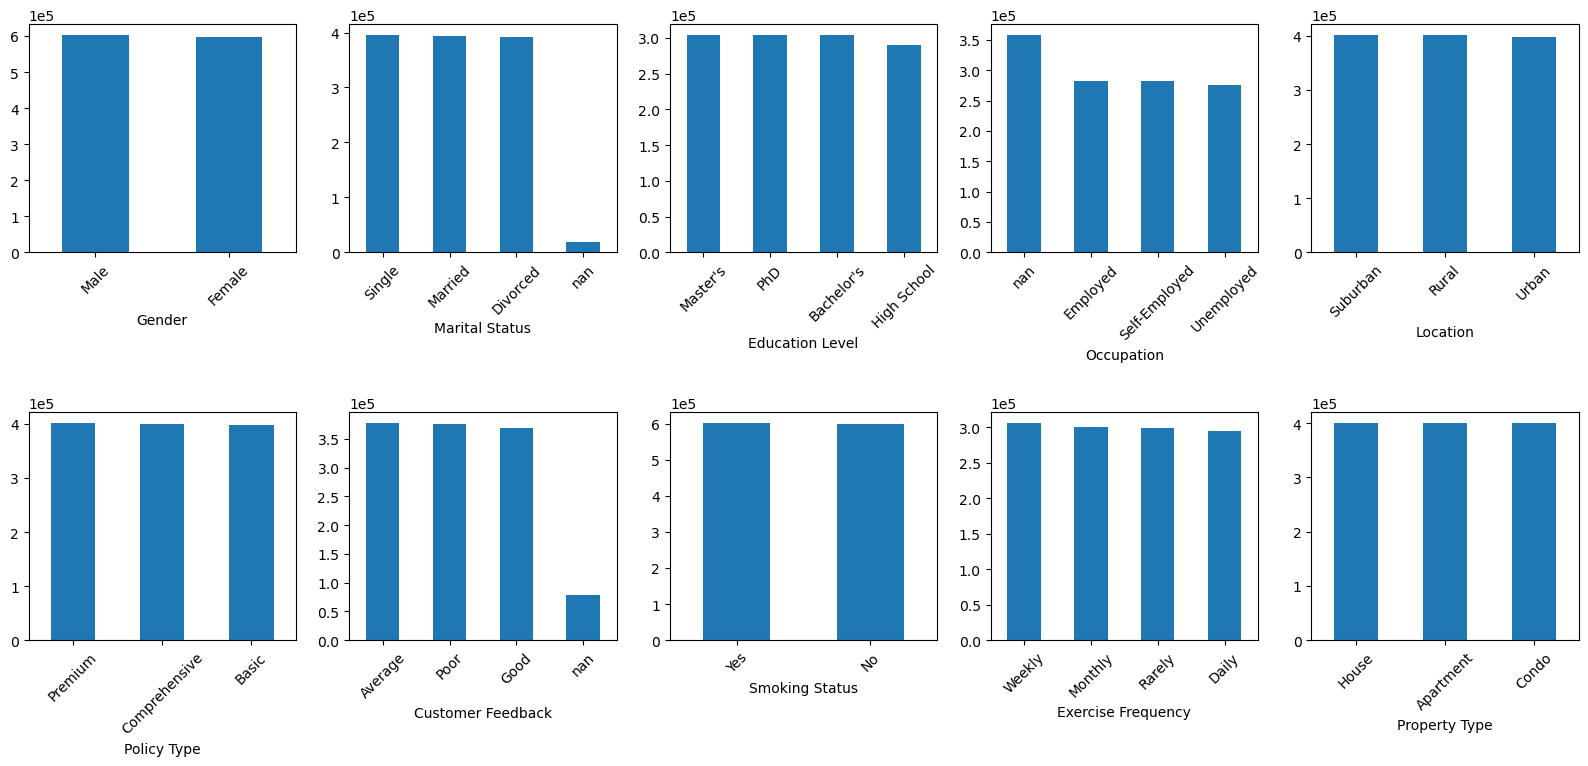

In [3]:
plt.figure(figsize=(20,8))
cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
for i,c in enumerate(cat_cols):
    plt.subplot(2,5,i+1)
    df[c].value_counts(dropna=False).plot(kind='bar')
    plt.ticklabel_format(axis='y',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.7)

## Plotting continuous features
Policy Start Date was converted to seconds since POSIX epoch so that it could be treated as a float. 
Age, Credit Score, Insurance Duration, Number of Dependents, Vehicle Age and Policy Start Date were all approximately uniformly distributed.
Annual Income, Premium Amount and Previous Claims were right-skewed
Health score was slightly right-skewed

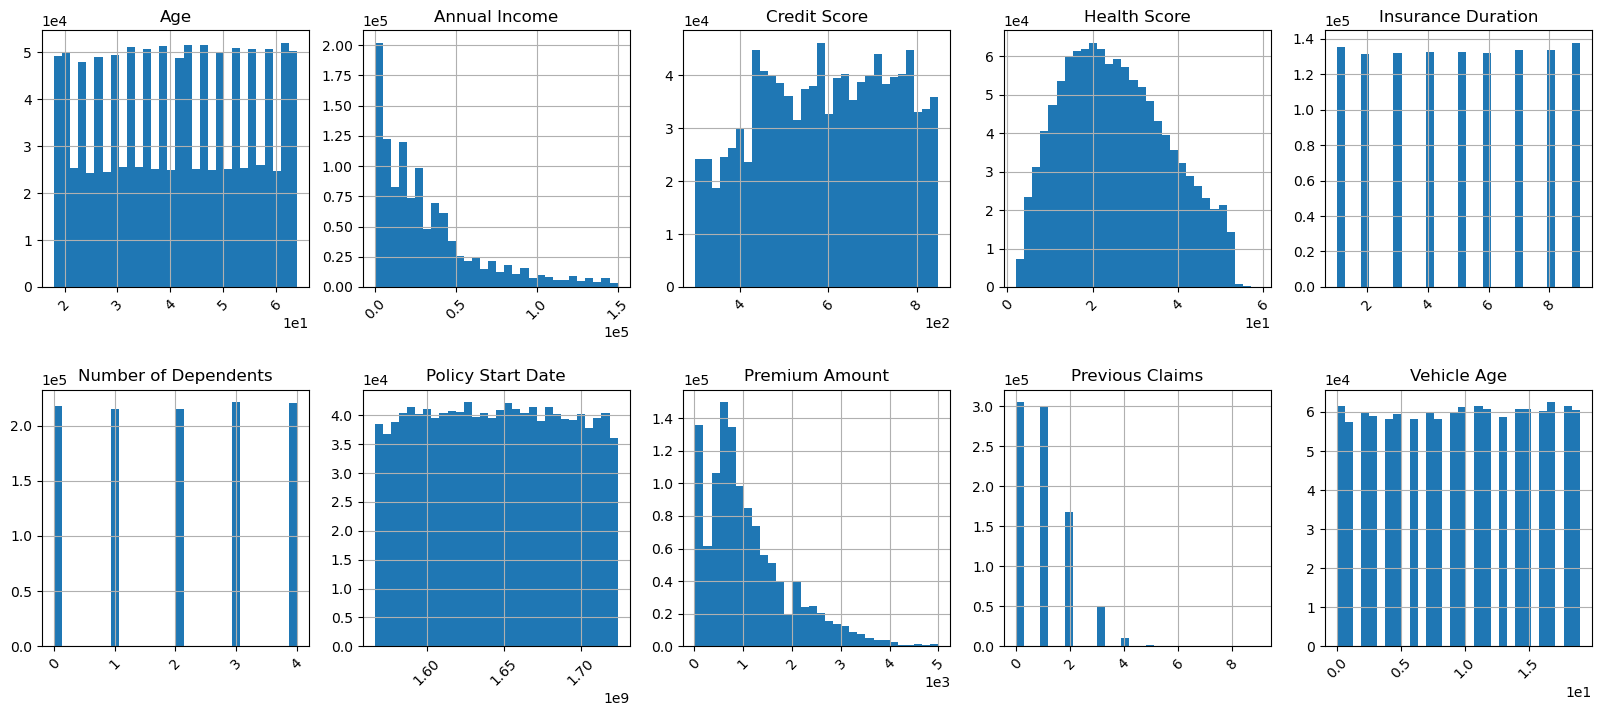

In [4]:
cont_cols = ['Age', 'Annual Income', 'Credit Score', 'Health Score',
       'Insurance Duration', 'Number of Dependents', 'Policy Start Date',
       'Premium Amount', 'Previous Claims', 'Vehicle Age']
plt.figure(figsize=(20,8))
for i,c in enumerate(cont_cols):
    plt.subplot(2,5,i+1)
    if c == 'Policy Start Date':
        pd.to_datetime(df[c]).apply(lambda x: x.timestamp()).hist(bins=30)
    else:
        df[c].hist(bins=30)
    plt.title(c)
    plt.ticklabel_format(axis='both',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)

## Missing values
Certain features have missing values, with Occupation and Previous Claims having 30% missing

## Preprocessing function
Based on the previous observations, a function to preprocess the data was prepared.

Previous claims had many missing values and few values greater than 2- to include these it was converted to categorical

***UPDATE FOR CATEGORICAL FEATURES***: 

Instead of one-hot encoding, this notebook retains the features as categorical dtype for use in the HistGradientBoosting function (which supports native categorical features). This reduces the number of features needed and avoids the creation of sparse features. Many of the categorical features are not ordinal, and so cannot be represented as continuous data.

In [5]:
from feature_engine.creation import CyclicalFeatures

In [6]:
def preprocess_data(df):
    cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
    # convert text features to categorical dtype after replacing missing values with new class
    for c in cat_cols:
        df[c] = df[c].astype('category')
    
    df['Previous Claims'] = df['Previous Claims'].clip(0,2).replace({0:'none',1:'one',2:'two_or_more'}).astype('category')

    cat_cols.append('Previous Claims')
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_cos'] = CyclicalFeatures(variables=['Month']).fit_transform(df)['Month_cos']
    df['Month_sin'] = CyclicalFeatures(variables=['Month']).fit_transform(df)['Month_sin']
    df['Day'] = df['Policy Start Date'].dt.day
    df['Day_cos'] = CyclicalFeatures(variables=['Day']).fit_transform(df)['Day_cos']
    df['Day_sin'] = CyclicalFeatures(variables=['Day']).fit_transform(df)['Day_sin']

    df['Policy Start Date'] = df['Policy Start Date'].apply(lambda x: x.timestamp()) / (3600*24*365.25)
    df['Annual Income'] = np.log1p(df['Annual Income'])
    df['Health Score'] = np.log1p(df['Health Score'])

    cont_cols = np.setdiff1d(df.columns,cat_cols)
    # impute missing values for remaining continuous features
    #df[cont_cols] = df[cont_cols].fillna(df[cont_cols].median())

    df['Policy End Date'] = df['Policy Start Date'] + df["Insurance Duration"]

    df = pd.get_dummies(df)
    return df

In [7]:
df = preprocess_data(df)
df_test = preprocess_data(df_test)

# Q1 = df['Premium Amount'].quantile(0.25)
# Q3 = df['Premium Amount'].quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = df['Premium Amount'].quantile(0.1) # Q1 - 1.5*IQR
# upper_limit = df['Premium Amount'].quantile(0.9) # Q3 + 1.5*IQR
# df = df.loc[(df['Premium Amount']>lower_limit) & (df['Premium Amount']<upper_limit)]

#df = df.loc[df['Premium Amount']>df['Premium Amount'].quantile(0.1)]

<Axes: >

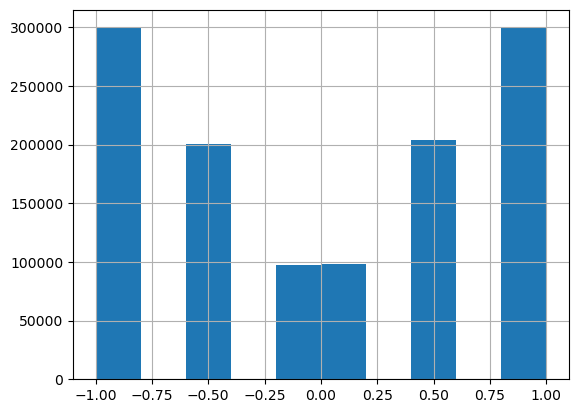

In [8]:
df['Month_sin'].hist()

<Axes: >

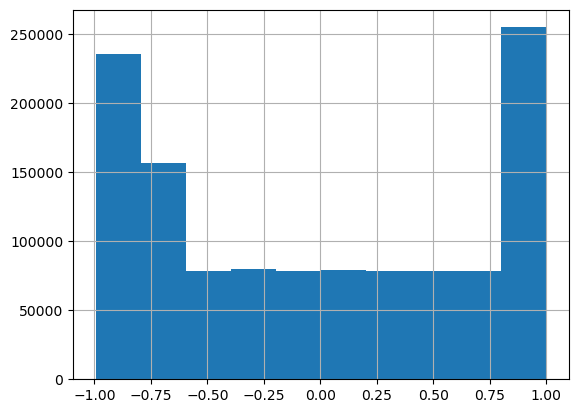

In [9]:
df['Day_cos'].hist()

<Axes: >

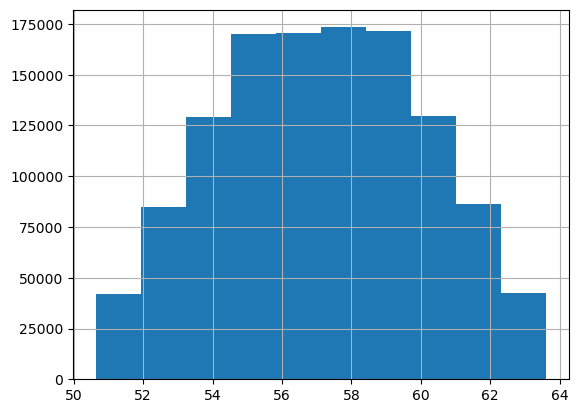

In [10]:
df['Policy End Date'].hist()

## Target definition
Premium Amount is the prediction target. The performance metric is the root mean square log error (RMSLE).
It differs from root mean square error (RMSE)in that RMSLE will penalize under-estimation more than over-estimation. To get good performance, we want to optimize our models for the squared log loss rather than the squared loss. However, squared loss is more commonly available as a loss in different ML algorithms. We can therefore take the log of the target in advance, so that we are effectively optimizing for RMSLE

In [11]:
target = df['Premium Amount']
# competition metric is root mean square log loss -> log-transform target first so that can use common mean-squares losses to optimize for the root mean square log loss
# will convert back predictions later
transformed_target = np.log1p(target)
X = df.drop(columns='Premium Amount')
Y = transformed_target = np.log1p(target)

# # Remove outliers
# Q1 = Y.quantile(0.25)
# Q3 = Y.quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = Q1 - 1.5*IQR
# upper_limit = Q3 + 1.5*IQR
# Y = Y.loc[(Y>lower_limit) & (Y<upper_limit)]
# X = X.loc[Y.index]


xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.9)

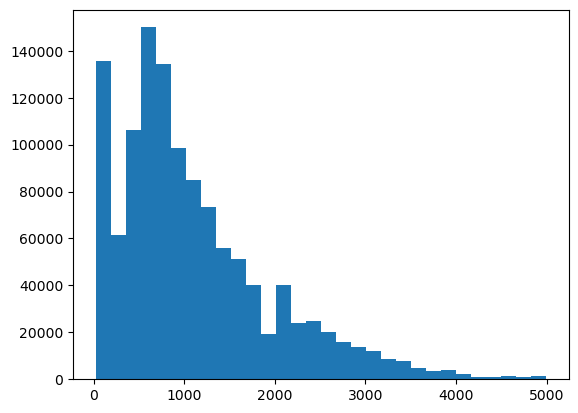

In [12]:
plt.hist(df['Premium Amount'],bins=30);

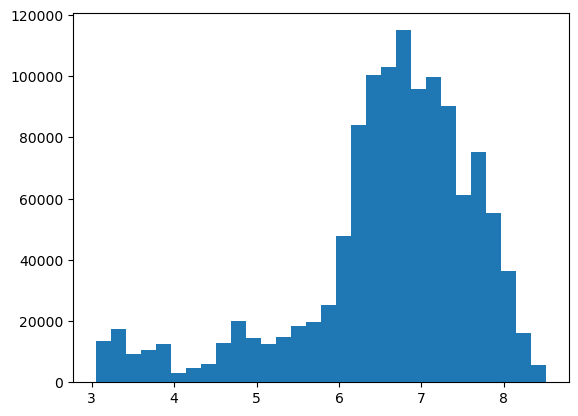

In [13]:
plt.hist(Y,bins=30);

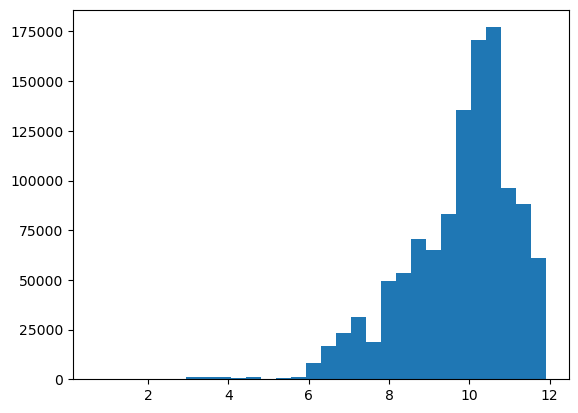

In [14]:
plt.hist(X['Annual Income'],bins=30);

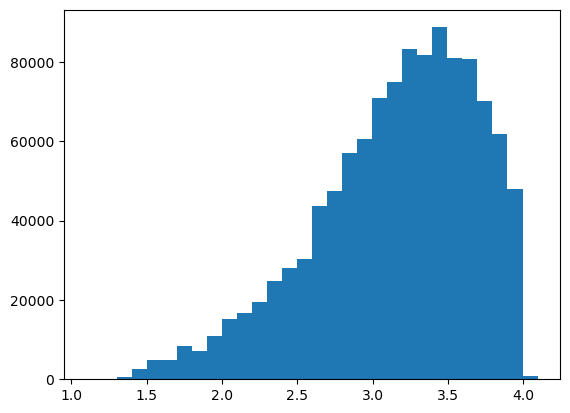

In [15]:
plt.hist(X['Health Score'],bins=30);

## Model fitting
Optimization using grid search and experiments with feature subsets were conducted. Minimal improvement was observed, and the biggest difference was between algorithms.

In [16]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.09,
    l2_regularization=1.52,
    min_samples_leaf=37,
    max_iter=3000,
    max_leaf_nodes=40,
    random_state=42,
    max_depth=13
    
)
print('%.4f'%np.mean(
    cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=10)
))

-1.0468


In [17]:
reg.fit(xtrain,ytrain)
root_mean_squared_error(ytest,reg.predict(xtest))

1.0451260312807957

In [18]:
# reg.fit(X,Y)
# pred = np.expm1(reg.predict(df_test))
# pd.DataFrame().from_dict({'id':df_test.index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)y

In [19]:
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
importance = permutation_importance(reg,xtest,ytest,scoring='neg_mean_squared_error',n_jobs=-1)
importance.pop('importances')
importance = pd.DataFrame().from_dict(importance)
importance.index = xtrain.columns

train: 1.0423760796936077
test: 1.0451260312807957


KeyboardInterrupt: 

<Axes: >

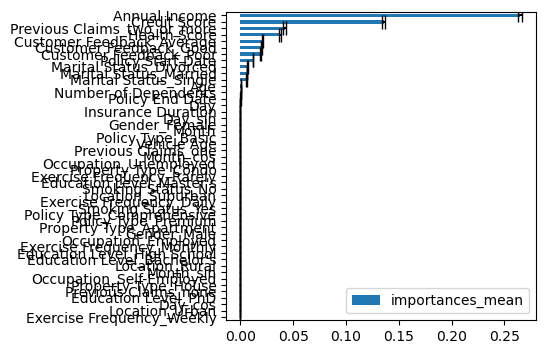

In [ ]:
importance.sort_values(by='importances_mean').plot(kind='barh',xerr='importances_std',capsize=5,figsize=(4,4))

In [20]:
import shap

c:\Users\Alex\anaconda3\envs\Portfolio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
X_subset = X.sample(100_000)
shap_values = shap.TreeExplainer(reg).shap_values(X_subset)

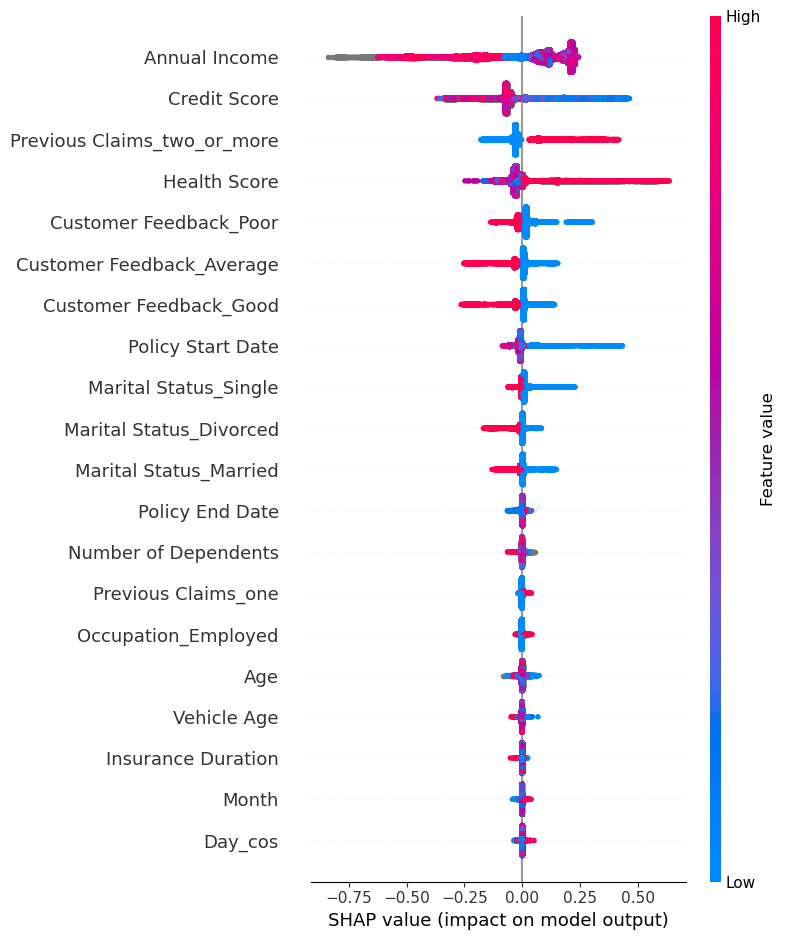

In [27]:
shap.summary_plot(shap_values,X_subset)

In [17]:
tmp = df[['Annual Income','Credit Score','Previous Claims','Health Score','Customer Feedback','Policy Start Date','Marital Status']]
tmp['transformed_target'] = transformed_target
pd.get_dummies(tmp.dropna()).corr()['transformed_target']

C:\Users\Alex\AppData\Local\Temp\ipykernel_16008\877095614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['transformed_target'] = transformed_target


Annual Income                 -0.054930
Credit Score                  -0.049201
Health Score                   0.009840
Policy Start Date             -0.009013
transformed_target             1.000000
Previous Claims_none          -0.019135
Previous Claims_one           -0.014009
Previous Claims_two_or_more    0.035886
Customer Feedback_Average     -0.001607
Customer Feedback_Good         0.000840
Customer Feedback_Poor         0.000772
Marital Status_Divorced       -0.002300
Marital Status_Married         0.001077
Marital Status_Single          0.001221
Name: transformed_target, dtype: float64

Need to explore the shap plots rather than these overall linear correlations

In [35]:
X_ohe = pd.get_dummies(X,drop_first=True)
X_ohe.head()

,Age,Annual Income,Number of Dependents,Health Score,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Month,Month_cos,...,Previous Claims_one,Previous Claims_two_or_more,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
id,,,,,,,,,,,,,,,,,,,,,
0,19.0,9.215328,1.0,3.161194,17.0,372.0,5.0,53.975743,12,1.000000e+00,...,False,True,False,True,False,False,False,True,False,True
1,39.0,10.363409,3.0,2.807578,12.0,694.0,2.0,53.444600,6,-1.000000e+00,...,True,False,False,False,True,True,False,False,False,True
2,23.0,10.150465,3.0,3.874893,14.0,NaN,3.0,53.745763,9,-1.836970e-16,...,True,False,True,False,True,False,False,True,False,True
3,21.0,11.862568,2.0,2.479739,0.0,367.0,1.0,54.446653,6,-1.000000e+00,...,True,False,False,True,True,False,False,False,False,False
4,21.0,10.587897,1.0,3.062273,8.0,598.0,4.0,51.916879,12,1.000000e+00,...,False,False,False,True,True,False,False,True,False,True


In [36]:
X_ohe.dropna(subset=X_ohe.select_dtypes('bool').columns,inplace=True)
X_ohe.fillna(X_ohe.median())

,Age,Annual Income,Number of Dependents,Health Score,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Month,Month_cos,...,Previous Claims_one,Previous Claims_two_or_more,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
id,,,,,,,,,,,,,,,,,,,,,
0,19.0,9.215328,1.0,3.161194,17.0,372.0,5.0,53.975743,12,1.000000e+00,...,False,True,False,True,False,False,False,True,False,True
1,39.0,10.363409,3.0,2.807578,12.0,694.0,2.0,53.444600,6,-1.000000e+00,...,True,False,False,False,True,True,False,False,False,True
2,23.0,10.150465,3.0,3.874893,14.0,595.0,3.0,53.745763,9,-1.836970e-16,...,True,False,True,False,True,False,False,True,False,True
3,21.0,11.862568,2.0,2.479739,0.0,367.0,1.0,54.446653,6,-1.000000e+00,...,True,False,False,True,True,False,False,False,False,False
4,21.0,10.587897,1.0,3.062273,8.0,598.0,4.0,51.916879,12,1.000000e+00,...,False,False,False,True,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,10.215264,0.0,2.692795,5.0,372.0,3.0,53.335086,5,-8.660254e-01,...,False,False,False,True,False,False,False,False,False,False
1199996,54.0,10.485340,2.0,2.524406,10.0,597.0,4.0,52.691691,9,-1.836970e-16,...,False,False,False,True,False,False,False,True,False,False
1199997,19.0,10.856785,0.0,2.755218,19.0,595.0,6.0,51.396687,5,-8.660254e-01,...,False,False,True,False,False,True,False,False,True,False


In [40]:
reg = HistGradientBoostingRegressor(
    learning_rate=0.09,
    l2_regularization=1.52,
    min_samples_leaf=37,
    max_iter=3000,
    max_leaf_nodes=40,
    random_state=42,
    max_depth=13
    
)
print('%.4f'%np.mean(
    cross_val_score(reg,X_ohe,Y,scoring='neg_root_mean_squared_error',cv=10)
))

-1.0515


In [55]:
shap_values = shap.Explainer(reg.predict,masker=X_ohe).shap_values(X_ohe)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
shap.dependence_plot("Premium Amount", shap_values, X)

In [ ]:
reg = RandomForestRegressor(
    min_samples_leaf=37,
    n_estimators=30,
    max_leaf_nodes=40,
    random_state=42,
    max_depth=13
)
print('%.4f'%np.mean(
    cross_val_score(reg,X_ohe,Y,scoring='neg_root_mean_squared_error',cv=10)
))

In [31]:
df.corr()['Premium Amount'].sort_values()

Annual Income                 -0.026427
Credit Score                  -0.026014
Previous Claims_none          -0.013193
Policy Start Date             -0.010111
Previous Claims_one           -0.007049
Customer Feedback_Average     -0.006422
Month_sin                     -0.005974
Policy End Date               -0.004901
Customer Feedback_Good        -0.004821
Customer Feedback_Poor        -0.002849
Age                           -0.002430
Marital Status_Married        -0.002184
Marital Status_Divorced       -0.001545
Education Level_PhD           -0.001252
Number of Dependents          -0.000976
Exercise Frequency_Weekly     -0.000887
Location_Rural                -0.000882
Property Type_House           -0.000804
Policy Type_Premium           -0.000792
Day_sin                       -0.000782
Marital Status_Single         -0.000656
Property Type_Condo           -0.000508
Day_cos                       -0.000459
Education Level_Master's      -0.000290
Exercise Frequency_Rarely     -0.000234
